In [1]:
import casadi as ca
import matplotlib.pyplot as plt
import numpy as np

# formulate problem

In [2]:
opti = ca.Opti()

# define optimization variables
A_A = opti.variable()
A_B = opti.variable()
U_pA = opti.variable()
U_pB = opti.variable()

# set constant parameters
c_fA = opti.parameter()
c_fB = opti.parameter()
p_pA = opti.parameter()
p_pB = opti.parameter()
s_A = opti.parameter()
s_B = opti.parameter()
A_tot = opti.parameter()
B_min = opti.parameter()
opti.set_value(c_fA, 150)
opti.set_value(c_fB, 100)
opti.set_value(p_pA, 3.9)
opti.set_value(p_pB, 3.9)
opti.set_value(s_A, 1.5)
opti.set_value(s_B, 1.45)
opti.set_value(A_tot, 100)
opti.set_value(B_min, 50000)

# set parameters for scenario 1
c_vA1 = opti.parameter()
c_vB1 = opti.parameter()
y_A1 = opti.parameter()
y_B1 = opti.parameter()
p_A1 = opti.parameter()
p_B1 = opti.parameter()
opti.set_value(c_vA1, 50)
opti.set_value(c_vB1, 150)
opti.set_value(y_A1, 800)
opti.set_value(y_B1, 150)
opti.set_value(p_A1, 2.5)
opti.set_value(p_B1, 5)

# set parameters for scenario 2
c_vA2 = opti.parameter()
c_vB2 = opti.parameter()
y_A2 = opti.parameter()
y_B2 = opti.parameter()
p_A2 = opti.parameter()
p_B2 = opti.parameter()
opti.set_value(c_vA2, 200)
opti.set_value(c_vB2, 40)
opti.set_value(y_A2, 300)
opti.set_value(y_B2, 600)
opti.set_value(p_A2, 4.5)
opti.set_value(p_B2, 3)

# harvested units in scenario 1
H_A1 = y_A1 * A_A
H_B1 = y_B1 * A_B
# harvested units in scenario 2
H_A2 = y_A2 * A_A
H_B2 = y_B2 * A_B

# cost
C1 = -(c_fA + c_vA1) * A_A - (c_fB + c_vB1) * A_B
B1 = ca.fmin(U_pA,H_A1) * p_pA + ca.fmin(U_pB,H_B1) * p_pB + ca.fmax(H_A1 - U_pA, 0) * p_A1 + ca.fmax(H_B1 - U_pB, 0) * p_B1
P1 = ca.fmin(H_A1 - U_pA, 0) * s_A + ca.fmin(H_B1 - U_pB, 0) * s_B

C2 = -(c_fA + c_vA2) * A_A - (c_fB + c_vB2) * A_B
B2 =  ca.fmin(U_pA,H_A2) * p_pA +  ca.fmin(U_pB,H_B2) * p_pB + ca.fmax(H_A2 - U_pA, 0) * p_A2 + ca.fmax(H_B2 - U_pB, 0) * p_B2
P2 = ca.fmin(H_A2 - U_pA, 0) * s_A + ca.fmin(H_B2 - U_pB, 0) * s_B

# constraints
opti.subject_to(A_A + A_B == A_tot)
opti.subject_to(A_A>0)
opti.subject_to(A_B>0)

opti.subject_to(U_pA>=0)
opti.subject_to(U_pB>=0)
opti.subject_to(U_pA+U_pB<800*100) # add some realistic upper bound on presale units

# constrain the presales --> do not allow to presell more than what can be harvested in the worst case
opti.subject_to(U_pA <= A_A*y_A1)
opti.subject_to(U_pA <= A_A*y_A2)
opti.subject_to(U_pB <= A_B*y_B1)
opti.subject_to(U_pB <= A_B*y_B2)

opti.subject_to(C1 + B1 + P1 >= B_min)
opti.subject_to(C2 + B2 + P2 >= B_min)


In [3]:
p_opts = {"expand":False,'verbose':0}
s_opts = {"print_level": 0, "sb": "yes"}#{"max_iter": 20}
opti.solver('ipopt', p_opts, s_opts)

## First, solve for one single scenario

### scenario 1 - wet summer

In [4]:
J = C1 + B1 + P1
opti.minimize(-J)
sol = opti.solve()
print('')
print('optimized scenario 1--------------------------------------------------------')
# Prepare values for table output
A_A_val = np.round(sol.value(A_A), 2)
A_B_val = np.round(sol.value(A_B), 2)
U_pA_val = int(np.round(sol.value(U_pA), 0))
U_pB_val = int(np.round(sol.value(U_pB), 0))
H_A1_val=np.round(sol.value(H_A1),0)
H_B1_val=np.round(sol.value(H_B1),0)
inc1=np.round((sol.value(C1)+sol.value(B1)+sol.value(P1))/1e3,2)
inc2=np.round((sol.value(C2)+sol.value(B2)+sol.value(P2))/1e3,2)

print("metric          | crop A   | crop B   |")
print("----------------|----------|----------|")
print(f"area            | {A_A_val:<8} | {A_B_val:<8} |")
print(f"pre-sells       | {U_pA_val:<8} | {U_pB_val:<8} |")
print(f"harvested units | {H_A1_val:<8} | {H_B1_val:<8} |")
print('')
print("scenario      | income [k$]  |")
print("--------------|--------------|")
print(f"1             | {inc1:<12} |")
print(f"2             | {inc2:<12} |")

print('---')
print("benefit B1:", sol.value(B1))
print("cost C1:", sol.value(C1))
print("penalty P1:", sol.value(P1))


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  93.00us (  5.81us)        16
       nlp_g  |        0 (       0) 233.00us ( 14.56us)        16
  nlp_grad_f  |        0 (       0) 182.00us ( 10.71us)        17
  nlp_hess_l  |        0 (       0)  28.00us (  1.87us)        15
   nlp_jac_g  |   1.00ms ( 58.82us) 488.00us ( 28.71us)        17
       total  |  35.00ms ( 35.00ms)  34.50ms ( 34.50ms)         1

optimized scenario 1--------------------------------------------------------
metric          | crop A   | crop B   |
----------------|----------|----------|
area            | 100.0    | 0.0      |
pre-sells       | 30000    | 0        |
harvested units | 80000.0  | 0.0      |

scenario      | income [k$]  |
--------------|--------------|
1             | 222.0        |
2             | 82.0         |
---
benefit B1: 241999.99999984604
cost C1: -20000.000000002754
penalty P1: 0.0


In [5]:
J = C2 + B2 + P2
opti.minimize(-J)
sol = opti.solve()
print('')
print('optimized scenario 2--------------------------------------------------------')
# Prepare values for table output
A_A_val = np.round(sol.value(A_A), 2)
A_B_val = np.round(sol.value(A_B), 2)
U_pA_val = int(np.round(sol.value(U_pA), 0))
U_pB_val = int(np.round(sol.value(U_pB), 0))
H_A2_val=np.round(sol.value(H_A2),0)
H_B2_val=np.round(sol.value(H_B2),0)
inc1=np.round((sol.value(C1)+sol.value(B1)+sol.value(P1))/1e3,2)
inc2=np.round((sol.value(C2)+sol.value(B2)+sol.value(P2))/1e3,2)

print("metric          | crop A   | crop B   |")
print("----------------|----------|----------|")
print(f"area            | {A_A_val:<8} | {A_B_val:<8} |")
print(f"pre-sells       | {U_pA_val:<8} | {U_pB_val:<8} |")
print(f"harvested units | {H_A2_val:<8} | {H_B2_val:<8} |")
print('')
print("scenario      | income [k$]  |")
print("--------------|--------------|")
print(f"1             | {inc1:<12} |")
print(f"2             | {inc2:<12} |")

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  73.00us (  6.08us)        12
       nlp_g  |   1.00ms ( 83.33us) 192.00us ( 16.00us)        12
  nlp_grad_f  |        0 (       0) 163.00us ( 12.54us)        13
  nlp_hess_l  |        0 (       0)  27.00us (  2.45us)        11
   nlp_jac_g  |        0 (       0) 445.00us ( 34.23us)        13
       total  |  16.00ms ( 16.00ms)  16.31ms ( 16.31ms)         1

optimized scenario 2--------------------------------------------------------
metric          | crop A   | crop B   |
----------------|----------|----------|
area            | 8.75     | 91.25    |
pre-sells       | 2626     | 13687    |
harvested units | 2626.0   | 54748.0  |

scenario      | income [k$]  |
--------------|--------------|
1             | 50.0         |
2             | 170.97       |


### optimize taking both scenarios into account (equally propable)

In [6]:
J = C1 + B1 + P1 + C2 + B2 + P2
opti.minimize(-J)
sol = opti.solve()
print('')
print('optimized for scenario 1&2 equally propable--------------------------------------------------------')
# Prepare values for table output
A_A_val = np.round(sol.value(A_A), 2)
A_B_val = np.round(sol.value(A_B), 2)
U_pA_val = int(np.round(sol.value(U_pA), 0))
U_pB_val = int(np.round(sol.value(U_pB), 0))

H_A1_val=np.round(sol.value(H_A1),0)
H_B1_val=np.round(sol.value(H_B1),0)
H_A2_val=np.round(sol.value(H_A2),0)
H_B2_val=np.round(sol.value(H_B2),0)
inc1=np.round((sol.value(C1)+sol.value(B1)+sol.value(P1))/1e3,2)
inc2=np.round((sol.value(C2)+sol.value(B2)+sol.value(P2))/1e3,2)

print("metric                        | crop A   | crop B   |")
print("------------------------------|----------|----------|")
print(f"area                         | {A_A_val:<8} | {A_B_val:<8} |")
print(f"pre-sells                    | {U_pA_val:<8} | {U_pB_val:<8} |")
print(f"harvested units (scenario 1) | {H_A1_val:<8} | {H_B1_val:<8} |")
print(f"harvested units (scenario 2) | {H_A2_val:<8} | {H_B2_val:<8} |")
print('')
print("scenario      | income [k$]  |")
print("--------------|--------------|")
print(f"1             | {inc1:<12} |")
print(f"2             | {inc2:<12} |")

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 172.00us (  8.19us)        21
       nlp_g  |        0 (       0) 287.00us ( 13.67us)        21
  nlp_grad_f  |        0 (       0) 361.00us ( 17.19us)        21
  nlp_hess_l  |        0 (       0)  39.00us (  2.05us)        19
   nlp_jac_g  |        0 (       0) 612.00us ( 29.14us)        21
       total  |  27.00ms ( 27.00ms)  26.63ms ( 26.63ms)         1

optimized for scenario 1&2 equally propable--------------------------------------------------------
metric                        | crop A   | crop B   |
------------------------------|----------|----------|
area                         | 100.0    | 0.0      |
pre-sells                    | 30000    | 0        |
harvested units (scenario 1) | 80000.0  | 0.0      |
harvested units (scenario 2) | 30000.0  | 0.0      |

scenario      | income [k$]  |
--------------|--------------|
1             | 222.0        |
2             | 82.0   

final solution:
- plant 100acres of crop A
- presell 30000 units of crop A

### BACKUP: testing stuff - WiP


find any solution in between by weighting in the cost function

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  68.00us (  5.67us)        12
       nlp_g  |   1.00ms ( 83.33us) 178.00us ( 14.83us)        12
  nlp_grad_f  |   1.00ms ( 76.92us) 160.00us ( 12.31us)        13
  nlp_hess_l  |        0 (       0)  26.00us (  2.36us)        11
   nlp_jac_g  |        0 (       0) 411.00us ( 31.62us)        13
       total  |  16.00ms ( 16.00ms)  15.46ms ( 15.46ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  53.00us (  4.42us)        12
       nlp_g  |        0 (       0)  83.00us (  6.92us)        12
  nlp_grad_f  |        0 (       0) 126.00us (  9.69us)        13
  nlp_hess_l  |        0 (       0)  14.00us (  1.27us)        11
   nlp_jac_g  |        0 (       0) 175.00us ( 13.46us)        13
       total  |   8.00ms (  8.00ms)   8.29ms (  8.29ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

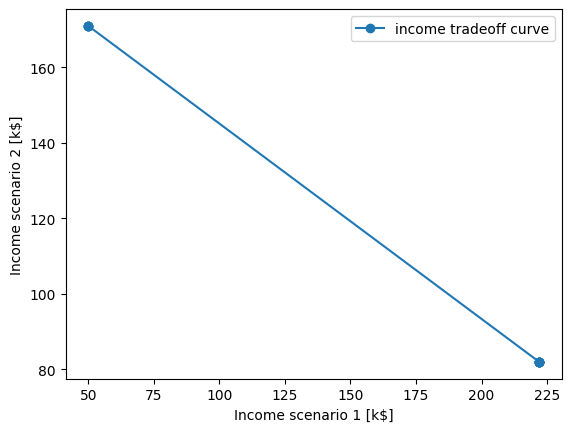

In [7]:
inc1_list = []
inc2_list = []
for alpha in range(0,11,1):
    alpha_i = alpha/10
    J = alpha_i*(C1 + B1 + P1) + (1-alpha_i)*(C2 + B2 + P2)
    opti.minimize(-J)
    sol = opti.solve()
    inc1 = np.round((sol.value(C1)+sol.value(B1)+sol.value(P1))/1e3,2)
    inc2 = np.round((sol.value(C2)+sol.value(B2)+sol.value(P2))/1e3,2)
    inc1_list.append(inc1)
    inc2_list.append(inc2)
plt.plot(inc1_list,inc2_list,label='income tradeoff curve',marker='o')
plt.xlabel('Income scenario 1 [k$]')
plt.ylabel('Income scenario 2 [k$]')
plt.legend()

In [8]:
alpha=0.5
J = alpha*(C1 + B1 + P1) + (1-alpha)*(C2 + B2 + P2)/(y_B2*100*p_B2)
opti.minimize(-J)
sol = opti.solve()
inc1 = np.round((sol.value(C1)+sol.value(B1)+sol.value(P1))/1e3,2)
inc2 = np.round((sol.value(C2)+sol.value(B2)+sol.value(P2))/1e3,2)
print(inc1)
print(inc2)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 107.00us (  6.69us)        16
       nlp_g  |        0 (       0) 131.00us (  8.19us)        16
  nlp_grad_f  |        0 (       0) 164.00us (  9.65us)        17
  nlp_hess_l  |        0 (       0)  17.00us (  1.13us)        15
   nlp_jac_g  |   1.00ms ( 58.82us) 220.00us ( 12.94us)        17
       total  |  13.00ms ( 13.00ms)  12.29ms ( 12.29ms)         1
222.0
82.0


In [9]:
A_A = 59
A_B = 100-A_A
U_pA = 0
U_pB = 0

# numerical test
y_A1 = 800
y_B1 = 150
y_A2 = 300
y_B2 = 600
c_fA = 150
c_fB = 100
c_vA1 = 50
c_vB1 = 150
c_vA2 = 200
c_vB2 = 40
p_pA = 3.9
p_pB = 3.9
s_A = 1.5
s_B = 1.45
p_A1 = 2.5
p_B1 = 5
p_A2 = 4.5
p_B2 = 3

# harvested units in scenario 1
H_A1 = y_A1 * A_A
H_B1 = y_B1 * A_B
# harvested units in scenario 2
H_A2 = y_A2 * A_A
H_B2 = y_B2 * A_B

# cost
C1 = -(c_fA + c_vA1) * A_A - (c_fB + c_vB1) * A_B
B1 = np.min([U_pA,H_A1]) * p_pA + np.min([U_pB,H_B1]) * p_pB + np.max([H_A1 - U_pA, 0]) * p_A1 + np.max([H_B1 - U_pB, 0]) * p_B1
P1 = np.min([H_A1 - U_pA, 0]) * s_A + np.min([H_B1 - U_pB, 0]) * s_B

C2 = -(c_fA + c_vA2) * A_A - (c_fB + c_vB2) * A_B
B2 = np.min([U_pA,H_A2]) * p_pA + np.min([U_pB,H_B2]) * p_pB + np.max([H_A2 - U_pA, 0]) * p_A2 + np.max([H_B2 - U_pB, 0]) * p_B2
P2 = np.min([H_A2 - U_pA, 0]) * s_A + np.min([H_B2 - U_pB, 0]) * s_B

print(C1+B1+P1)
print(C2+B2+P2)

126700.0
127060.0


In [10]:
np.min((U_pA,H_A1))

np.int64(0)